# Анализ данных датчиков

Этот ноутбук содержит полный цикл обработки данных с датчиков (ESP32-S3 + MH-Z19C + DHT-22):
1. Извлечение данных из DynamoDB
2. Очистка данных
3. Нормализация данных
4. Разметка данных
5. Анализ данных
6. Экспорт результатов

## 1. Извлечение данных из DynamoDB

In [1]:
import boto3
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from decimal import Decimal

plt.rcParams['figure.figsize'] = (15, 6)
sns.set_style('whitegrid')

In [2]:
# Подключение к DynamoDB
session = boto3.Session(profile_name='personal')
dynamodb = session.resource('dynamodb', region_name='eu-central-1')
table = dynamodb.Table('co2-sensor-data')

device_id = 'esp32-001'
days_back = 30
start_time = int((datetime.now() - timedelta(days=days_back)).timestamp() * 1000)

print(f"Загрузка данных за последние {days_back} дней...")
response = table.query(
    KeyConditionExpression='deviceId = :did AND #ts >= :start',
    ExpressionAttributeNames={'#ts': 'timestamp'},
    ExpressionAttributeValues={':did': device_id, ':start': start_time}
)

data = [{k: float(v) if isinstance(v, Decimal) else v for k, v in item.items()} for item in response['Items']]

with open('sensor_data.json', 'w') as f:
    json.dump(data, f, indent=2)

print(f"Загружено {len(data)} записей")

Загрузка данных за последние 30 дней...
Загружено 400 записей


In [3]:
# Преобразование в DataFrame
df = pd.DataFrame(data)
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
df['datetime'] = df['datetime'].dt.tz_convert('Asia/Ashgabat')  # GMT+5
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"Период данных: {df['datetime'].min()} - {df['datetime'].max()}")
print(f"\nПервые записи:")
df.head()

Период данных: 2025-11-02 20:46:13+05:00 - 2025-11-22 18:17:51+05:00

Первые записи:


,ttl,humidity,deviceId,co2,temperature,timestamp,datetime
0,1.793635e+09,39.9,esp32-001,943.0,24.34,1.762098e+12,2025-11-02 20:46:13+05:00
1,1.793635e+09,40.0,esp32-001,914.0,24.34,1.762098e+12,2025-11-02 20:46:28+05:00
2,1.793635e+09,40.2,esp32-001,935.0,24.33,1.762098e+12,2025-11-02 20:46:43+05:00
3,1.793635e+09,39.9,esp32-001,929.0,24.32,1.762098e+12,2025-11-02 20:46:57+05:00
4,1.793635e+09,39.8,esp32-001,921.0,24.31,1.762098e+12,2025-11-02 20:47:12+05:00


## 2. Очистка данных

### 2.1. Анализ временных меток

Устройство работает в трех режимах:
- **Онлайн**: синхронизация с NTP, точные временные метки
- **Оффлайн (после синхронизации)**: продолжение с последнего известного времени + 10 сек
- **Оффлайн (без синхронизации)**: относительное время от включения устройства

Необходимо выявить разрывы и аномалии во временных метках.

Статистика интервалов между измерениями (сек):
count       399.000000
mean       4308.516291
std       44971.386981
min           8.776000
25%          18.000000
50%          19.000000
75%          20.000000
max      553091.000000
Name: time_diff, dtype: float64


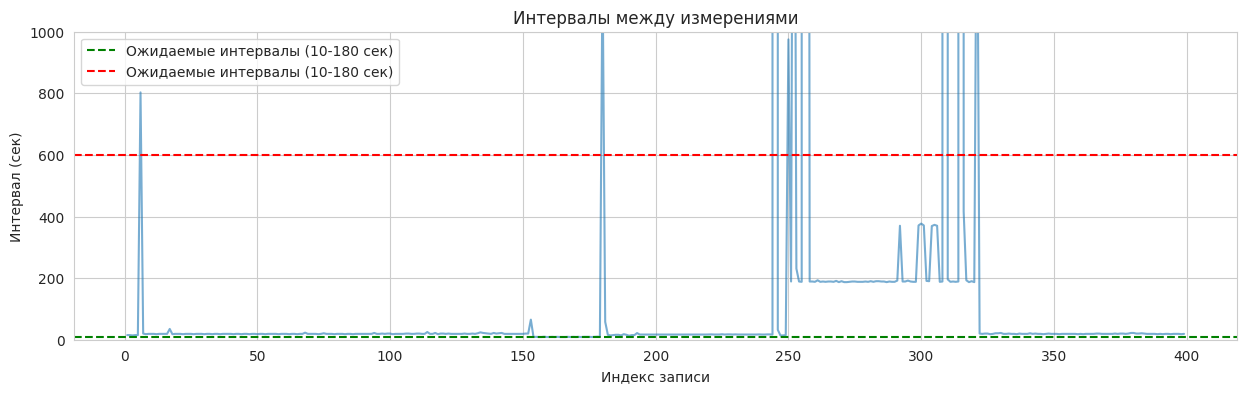


Найдено 10 разрывов более 5 минут:


In [4]:
# Анализ интервалов между измерениями
df['time_diff'] = df['timestamp'].diff() / 1000  # в секундах

print("Статистика интервалов между измерениями (сек):")
print(df['time_diff'].describe())

# Визуализация интервалов
plt.figure(figsize=(15, 4))
plt.plot(df.index, df['time_diff'], alpha=0.6)
plt.axhline(y=10, color='g', linestyle='--', label='Ожидаемые интервалы (10-180 сек)')
plt.axhline(y=600, color='r', linestyle='--', label='Ожидаемые интервалы (10-180 сек)')
plt.xlabel('Индекс записи')
plt.ylabel('Интервал (сек)')
plt.title('Интервалы между измерениями')
plt.legend()
plt.ylim(0, 1000)
plt.show()

# Поиск больших разрывов (более 10 минут)
gaps = df[df['time_diff'] > 600].copy()
print(f"\nНайдено {len(gaps)} разрывов более 5 минут:")
if len(gaps) > 0:
    gaps[['datetime', 'time_diff']].head(10)

### 2.2. Идентификация сессий измерений

Разделим данные на сессии по большим временным разрывам (>10 минут, т.е. больше 3 пропусков отправки телеметрии).

In [5]:
# Создание ID сессий
df['session_id'] = (df['time_diff'] > 600).cumsum()  # разрыв > 10 минут

df['температура'] = df['temperature']
df['влажность'] = df['humidity']

# Статистика по сессиям
session_stats = df.groupby('session_id').agg({
    'datetime': ['min', 'max', 'count'],
    'температура': 'mean',
    'влажность': 'mean',
    'co2': 'mean'
})

session_stats.columns = ['Начало', 'Конец', 'Записей', 'Ср.Темп', 'Ср.Влажн', 'Ср.CO2']
session_stats['Длительность'] = (session_stats['Конец'] - session_stats['Начало'])

print(f"Найдено {len(session_stats)} сессий измерений:\n")
session_stats

Найдено 11 сессий измерений:



,Начало,Конец,Записей,Ср.Темп,Ср.Влажн,Ср.CO2,Длительность
session_id,,,,,,,
0,2025-11-02 20:46:13+05:00,2025-11-02 20:47:27+05:00,6,24.325000,39.983333,931.500000,0 days 00:01:14
1,2025-11-02 21:00:50+05:00,2025-11-02 21:52:54.028000+05:00,174,24.166092,40.264368,1048.379310,0 days 00:52:04.028000
2,2025-11-02 22:13:08+05:00,2025-11-02 22:31:38.916999936+05:00,65,21.536615,44.712121,1447.830769,0 days 00:18:30.916999936
3,2025-11-08 21:06:24+05:00,2025-11-08 21:07:39+05:00,5,22.358000,39.140000,966.600000,0 days 00:01:15
4,2025-11-08 21:23:54+05:00,2025-11-08 21:27:03+05:00,2,24.465000,44.100000,399.000000,0 days 00:03:09
5,2025-11-08 22:13:26+05:00,2025-11-08 22:23:34+05:00,4,24.032500,39.800000,971.500000,0 days 00:10:08
6,2025-11-14 09:02:21+05:00,2025-11-14 09:02:21+05:00,1,23.070000,NaN,1267.000000,0 days 00:00:00
7,2025-11-14 11:15:37+05:00,2025-11-14 14:17:30+05:00,52,23.886538,45.151923,2046.076923,0 days 03:01:53
8,2025-11-20 23:55:41+05:00,2025-11-21 00:11:31+05:00,6,23.633333,38.350000,554.333333,0 days 00:15:50


Сессия с индексом 7 наиболее достоверная, охватывает период без больших разрывов, включает достаточно длительный период измерений.

In [6]:
df14=df[df["session_id"]==7]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype                        
---  ------       --------------  -----                        
 0   ttl          400 non-null    float64                      
 1   humidity     365 non-null    float64                      
 2   deviceId     400 non-null    object                       
 3   co2          400 non-null    float64                      
 4   temperature  400 non-null    float64                      
 5   timestamp    400 non-null    float64                      
 6   datetime     400 non-null    datetime64[ns, Asia/Ashgabat]
 7   time_diff    399 non-null    float64                      
 8   session_id   400 non-null    int64                        
 9   температура  400 non-null    float64                      
 10  влажность    365 non-null    float64                      
dtypes: datetime64[ns, Asia/Ashgabat](1), float64(8), int64(1),

### 2.3. Удаление артефактов

Используем метод 3-сигма для удаления аномальных значений. Артефакты часто возникают при включении/выключении устройства.

In [7]:
def remove_outliers_3sigma(df, column):
    mean = df[column].mean()
    std = df[column].std()
    lower = mean - 3 * std
    upper = mean + 3 * std
    outliers = (df[column] < lower) | (df[column] > upper)
    print(f"{column}: удалено {outliers.sum()} выбросов (диапазон: {lower:.2f} - {upper:.2f})")
    return ~outliers

# Применение фильтра
mask = remove_outliers_3sigma(df14, 'температура') & \
       remove_outliers_3sigma(df14, 'влажность') & \
       remove_outliers_3sigma(df14, 'co2')

df_clean = df14[mask].copy()
print(f"\nОсталось {len(df_clean)} из {len(df)} записей ({len(df_clean)/len(df)*100:.1f}%)")

температура: удалено 2 выбросов (диапазон: 22.65 - 25.12)
влажность: удалено 1 выбросов (диапазон: 38.31 - 52.00)
co2: удалено 0 выбросов (диапазон: 1079.26 - 3012.89)

Осталось 50 из 400 записей (12.5%)


### 2.4. Удаление краевых эффектов

Удаляем первые 5 минут каждой сессии (стабилизация датчиков).

In [8]:
# Удаление первых 5 минут каждой сессии
def remove_session_edges(group):
    start_time = group['timestamp'].min()
    return group[group['timestamp'] > start_time + 300000]  # +5 минут в мс

df_clean = df_clean.groupby('session_id', group_keys=False).apply(remove_session_edges)
print(f"После удаления краевых эффектов: {len(df_clean)} записей")

После удаления краевых эффектов: 48 записей


## 3. Нормализация данных

### 3.1. Сглаживание данных

Применяем скользящее среднее для уменьшения шума датчиков.

In [9]:
# Скользящее среднее (окно 5 измерений = 15 минут)
window = 10
df_clean['сглаженная_температура'] = df_clean['температура'].rolling(window=window, center=True).mean()
df_clean['сглаженная_влажность'] = df_clean['влажность'].rolling(window=window, center=True).mean()
df_clean['сглаженный_co2'] = df_clean['co2'].rolling(window=window, center=True).mean()

# Заполнение NaN на краях
df_clean['сглаженная_температура'].fillna(df_clean['температура'], inplace=True)
df_clean['сглаженная_влажность'].fillna(df_clean['влажность'], inplace=True)
df_clean['сглаженный_co2'].fillna(df_clean['co2'], inplace=True)

print("Сглаживание применено (окно 15 минут)")

Сглаживание применено (окно 15 минут)


### 3.2. Визуализация до и после нормализации

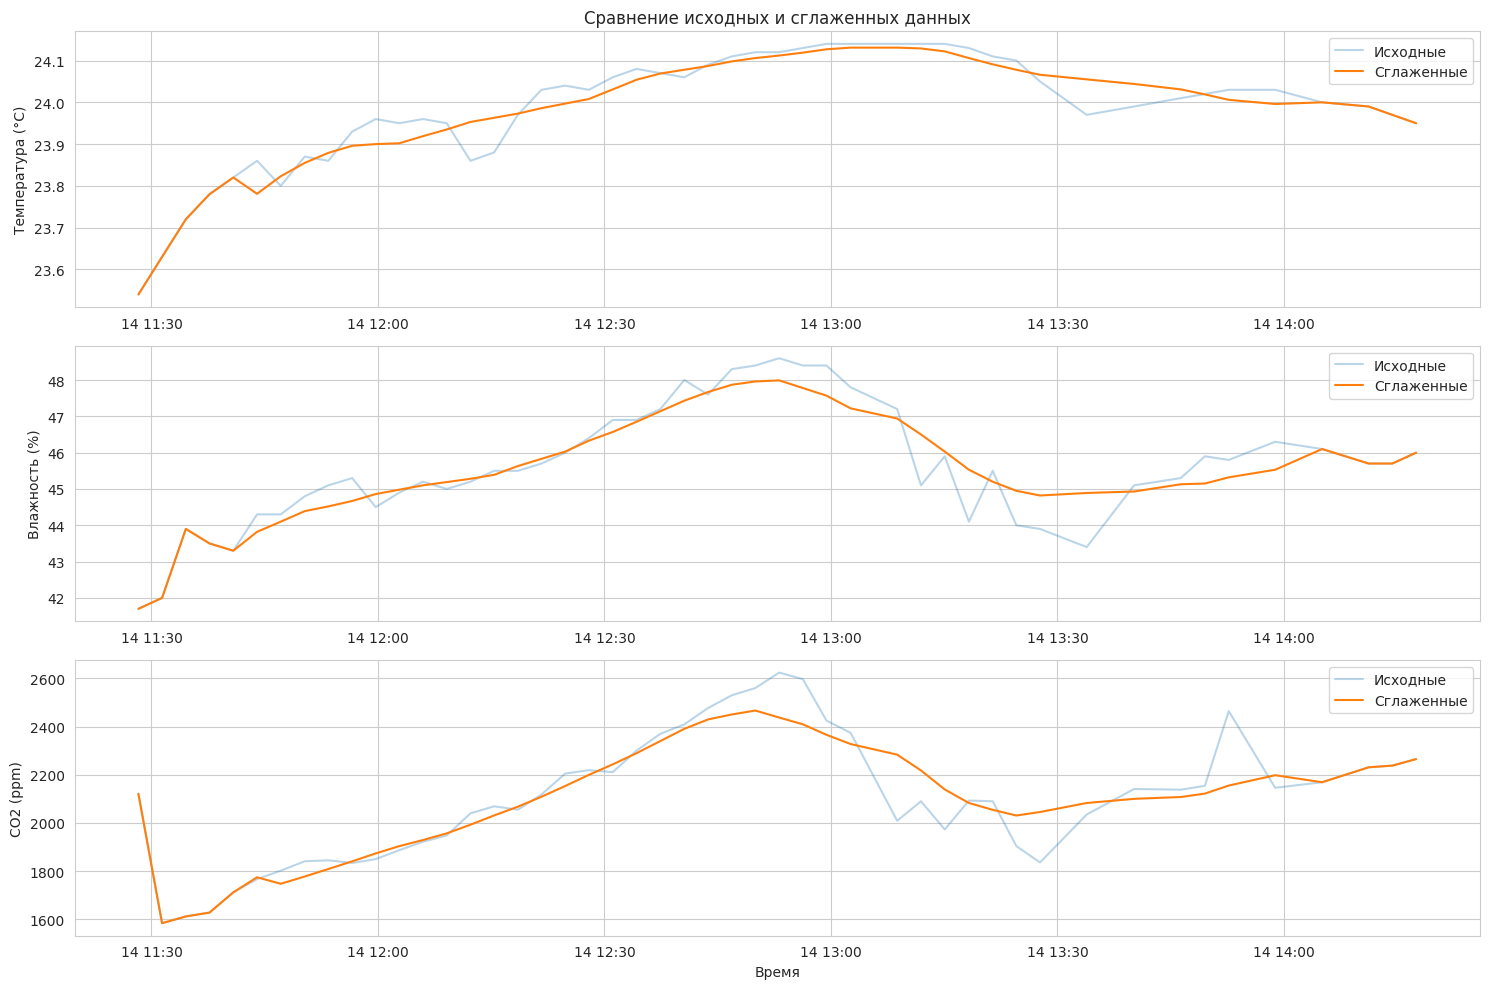

In [10]:
# Сравнение исходных и сглаженных данных
sample = df_clean.iloc[:500]  # первые 500 записей для примера

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

axes[0].plot(sample['datetime'], sample['температура'], alpha=0.3, label='Исходные')
axes[0].plot(sample['datetime'], sample['сглаженная_температура'], label='Сглаженные')
axes[0].set_ylabel('Температура (°C)')
axes[0].legend()
axes[0].set_title('Сравнение исходных и сглаженных данных')

axes[1].plot(sample['datetime'], sample['влажность'], alpha=0.3, label='Исходные')
axes[1].plot(sample['datetime'], sample['сглаженная_влажность'], label='Сглаженные')
axes[1].set_ylabel('Влажность (%)')
axes[1].legend()

axes[2].plot(sample['datetime'], sample['co2'], alpha=0.3, label='Исходные')
axes[2].plot(sample['datetime'], sample['сглаженный_co2'], label='Сглаженные')
axes[2].set_ylabel('CO2 (ppm)')
axes[2].legend()
axes[2].set_xlabel('Время')

plt.tight_layout()
plt.show()

## 4. Разметка данных

### 4.1. Определение меток для временных интервалов

Привязываем метки к конкретным временным интервалам:
- **14 ноября**: Кабинет 240 (Информатика, 15 человек, 80 м³)

In [11]:
# Инициализация колонок для меток
df_clean['Кабинет'] = None
df_clean['Примечание'] = None
df_clean['Объем (куб)'] = None
df_clean['Заполненность (чел)'] = None

# 14 ноября - Кабинет 240
nov14_start = pd.Timestamp('2025-11-14 00:00:00', tz='Asia/Ashgabat')
nov14_end = pd.Timestamp('2025-11-15 00:00:00', tz='Asia/Ashgabat')
mask_nov14 = (df_clean['datetime'] >= nov14_start) & (df_clean['datetime'] < nov14_end)
df_clean.loc[mask_nov14, 'Кабинет'] = '240'
df_clean.loc[mask_nov14, 'Примечание'] = 'Кабинет информатики'
df_clean.loc[mask_nov14, 'Объем (куб)'] = 80
df_clean.loc[mask_nov14, 'Заполненность (чел)'] = 15


print("\nСтатистика разметки:")
print(df_clean['Кабинет'].value_counts())
print(f"\nРазмечено: {df_clean['Кабинет'].notna().sum()} из {len(df_clean)} записей")


Статистика разметки:
240    48
Name: Кабинет, dtype: int64

Размечено: 48 из 48 записей


In [12]:
# Создание финального датасета только с размеченными данными
df_labeled = df_clean[df_clean['Кабинет'].notna()].copy()
print(f"Финальный датасет: {len(df_labeled)} записей")
print(f"\nПериоды измерений по кабинетам:")
for cabinet in df_labeled['Кабинет'].unique():
    subset = df_labeled[df_labeled['Кабинет'] == cabinet]
    print(f"\nКабинет {cabinet}:")
    print(f"  Период: {subset['datetime'].min()} - {subset['datetime'].max()}")
    print(f"  Записей: {len(subset)}")
    print(f"  Длительность: {(subset['datetime'].max() - subset['datetime'].min())}")

Финальный датасет: 48 записей

Периоды измерений по кабинетам:

Кабинет 240:
  Период: 2025-11-14 11:28:16+05:00 - 2025-11-14 14:17:30+05:00
  Записей: 48
  Длительность: 0 days 02:49:14


## 5. Анализ данных

### 5.1. Общая статистика по кабинетам

In [13]:
# Агрегированная статистика
stats = df_labeled.groupby('Кабинет').agg({
    'сглаженная_температура': ['mean', 'min', 'max', 'std'],
    'сглаженная_влажность': ['mean', 'min', 'max', 'std'],
    'сглаженный_co2': ['mean', 'min', 'max', 'std'],
    'Заполненность (чел)': 'first',
    'Объем (куб)': 'first'
}).round(2)

stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
print("Статистика по кабинетам:\n")
stats

Статистика по кабинетам:



,сглаженная_температура_mean,сглаженная_температура_min,сглаженная_температура_max,сглаженная_температура_std,сглаженная_влажность_mean,сглаженная_влажность_min,сглаженная_влажность_max,сглаженная_влажность_std,сглаженный_co2_mean,сглаженный_co2_min,сглаженный_co2_max,сглаженный_co2_std,Заполненность (чел)_first,Объем (куб)_first
Кабинет,,,,,,,,,,,,,,
240,23.98,23.54,24.13,0.13,45.56,41.7,47.99,1.44,2093.67,1584.0,2466.6,233.79,15,80


### 5.2. Расчет производных метрик

Рассчитываем плотность заполнения и удельную концентрацию CO2.

In [14]:
# Плотность заполнения (человек на м³)
df_labeled['Плотность (чел/м³)'] = df_labeled['Заполненность (чел)'] / df_labeled['Объем (куб)']

# Удельная концентрация CO2 (ppm на человека)
df_labeled['CO2 на человека'] = df_labeled['сглаженный_co2'] / df_labeled['Заполненность (чел)']

print("Производные метрики:\n")
derived_stats = df_labeled.groupby('Кабинет').agg({
    'Плотность (чел/м³)': 'first',
    'CO2 на человека': 'mean'
}).round(2)
derived_stats

Производные метрики:



,Плотность (чел/м³),CO2 на человека
Кабинет,,
240,0.1875,139.58


### 5.3. Визуализация динамики по дням

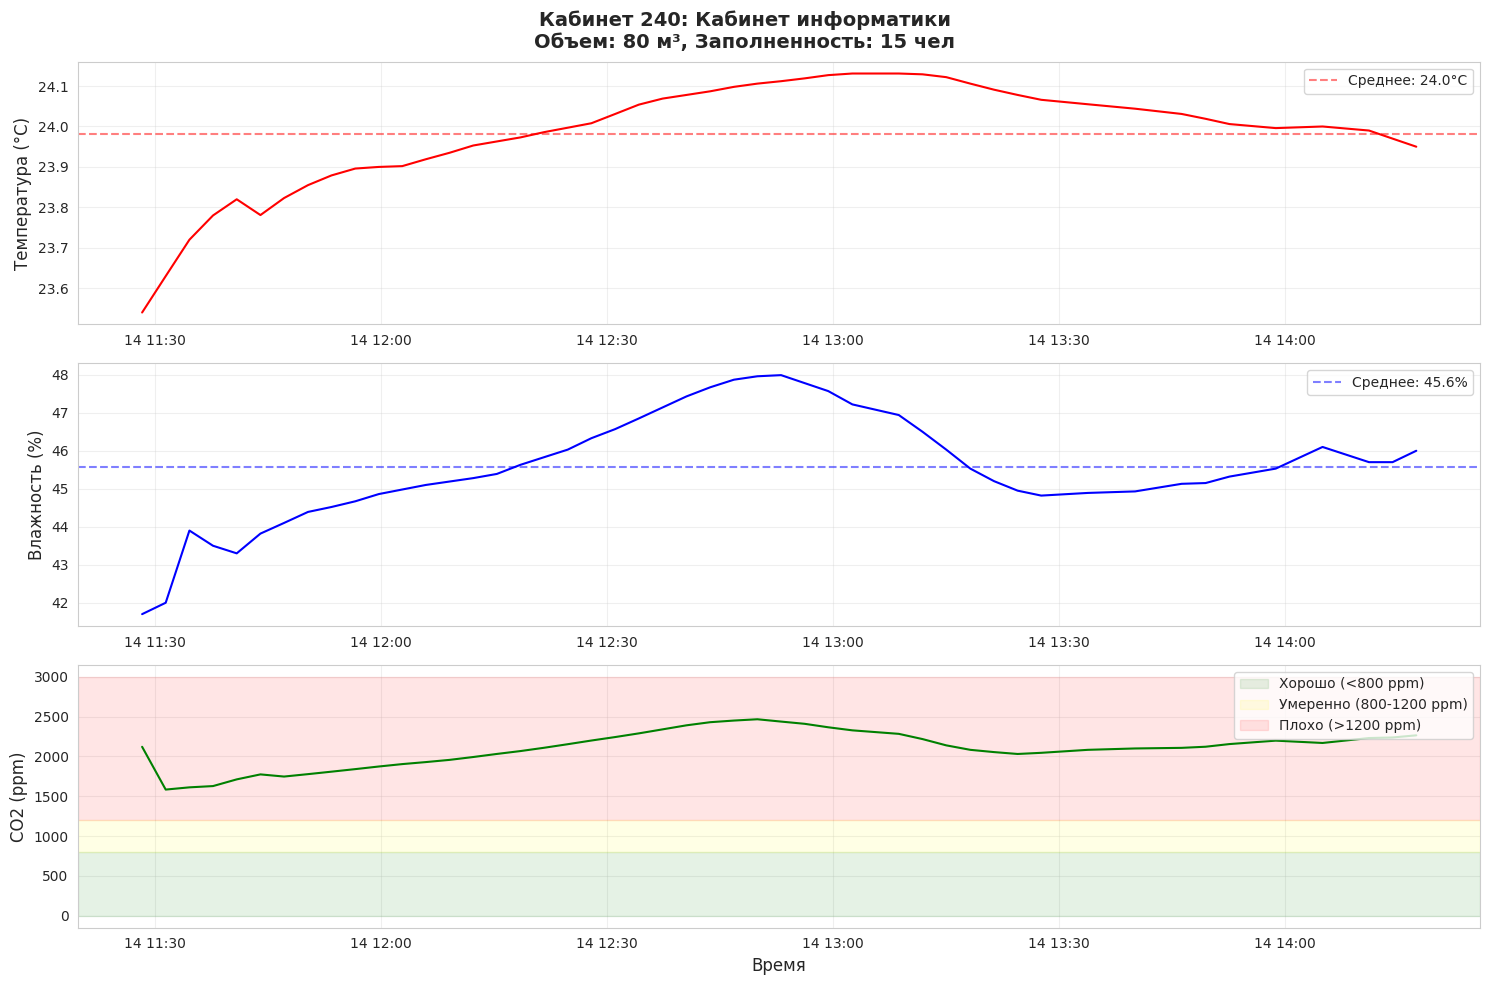


Кабинет 240 - Распределение по зонам CO2:
  Хорошо (<800 ppm): 0.0%
  Умеренно (800-1200 ppm): 0.0%
  Плохо (>1200 ppm): 100.0%



In [15]:
# График для каждого кабинета
cabinets = df_labeled['Кабинет'].unique()

for cabinet in cabinets:
    data = df_labeled[df_labeled['Кабинет'] == cabinet]
    info = data.iloc[0]

    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    fig.suptitle(f"Кабинет {cabinet}: {info['Примечание']}\n" +
                 f"Объем: {info['Объем (куб)']} м³, Заполненность: {info['Заполненность (чел)']} чел",
                 fontsize=14, fontweight='bold')

    axes[0].plot(data['datetime'], data['сглаженная_температура'], color='red', linewidth=1.5)
    axes[0].set_ylabel('Температура (°C)', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=data['сглаженная_температура'].mean(), color='red', linestyle='--', alpha=0.5,
                    label=f"Среднее: {data['сглаженная_температура'].mean():.1f}°C")
    axes[0].legend()

    axes[1].plot(data['datetime'], data['сглаженная_влажность'], color='blue', linewidth=1.5)
    axes[1].set_ylabel('Влажность (%)', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=data['сглаженная_влажность'].mean(), color='blue', linestyle='--', alpha=0.5,
                    label=f"Среднее: {data['сглаженная_влажность'].mean():.1f}%")
    axes[1].legend()

    axes[2].plot(data['datetime'], data['сглаженный_co2'], color='green', linewidth=1.5)
    axes[2].axhspan(0, 800, alpha=0.1, color='green', label='Хорошо (<800 ppm)')
    axes[2].axhspan(800, 1200, alpha=0.1, color='yellow', label='Умеренно (800-1200 ppm)')
    axes[2].axhspan(1200, 3000, alpha=0.1, color='red', label='Плохо (>1200 ppm)')
    axes[2].set_ylabel('CO2 (ppm)', fontsize=12)
    axes[2].set_xlabel('Время', fontsize=12)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    total_records = len(data)
    good = (data['сглаженный_co2'] < 800).sum()
    moderate = ((data['сглаженный_co2'] >= 800) & (data['сглаженный_co2'] < 1200)).sum()
    poor = (data['сглаженный_co2'] >= 1200).sum()

    print(f"\nКабинет {cabinet} - Распределение по зонам CO2:")
    print(f"  Хорошо (<800 ppm): {good/total_records*100:.1f}%")
    print(f"  Умеренно (800-1200 ppm): {moderate/total_records*100:.1f}%")
    print(f"  Плохо (>1200 ppm): {poor/total_records*100:.1f}%")
    print()

### 5.4. Сравнительный анализ кабинетов

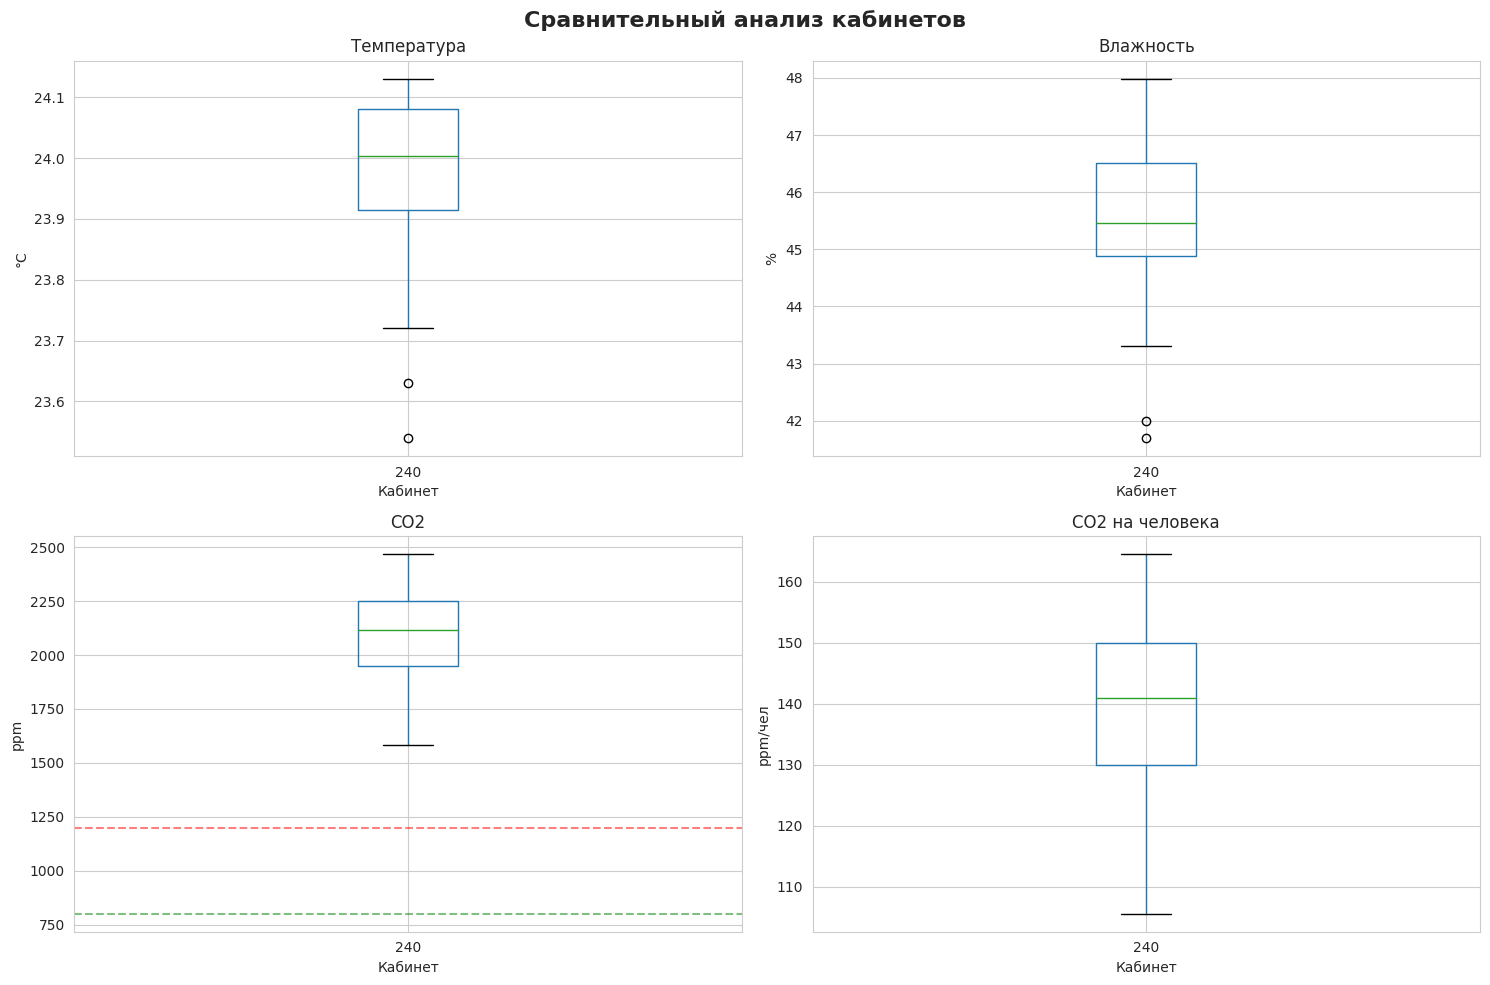

In [16]:
# Сравнение средних значений
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Сравнительный анализ кабинетов', fontsize=16, fontweight='bold')

df_labeled.boxplot(column='сглаженная_температура', by='Кабинет', ax=axes[0, 0])
axes[0, 0].set_title('Температура')
axes[0, 0].set_ylabel('°C')
axes[0, 0].set_xlabel('Кабинет')

df_labeled.boxplot(column='сглаженная_влажность', by='Кабинет', ax=axes[0, 1])
axes[0, 1].set_title('Влажность')
axes[0, 1].set_ylabel('%')
axes[0, 1].set_xlabel('Кабинет')

df_labeled.boxplot(column='сглаженный_co2', by='Кабинет', ax=axes[1, 0])
axes[1, 0].set_title('CO2')
axes[1, 0].set_ylabel('ppm')
axes[1, 0].set_xlabel('Кабинет')
axes[1, 0].axhline(y=800, color='green', linestyle='--', alpha=0.5)
axes[1, 0].axhline(y=1200, color='red', linestyle='--', alpha=0.5)

df_labeled.boxplot(column='CO2 на человека', by='Кабинет', ax=axes[1, 1])
axes[1, 1].set_title('CO2 на человека')
axes[1, 1].set_ylabel('ppm/чел')
axes[1, 1].set_xlabel('Кабинет')

plt.tight_layout()
plt.suptitle('Сравнительный анализ кабинетов', fontsize=16, fontweight='bold')
plt.show()

### 5.5. Корреляционный анализ

/tmp/ipykernel_26901/2635435166.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_labeled[corr_cols].corr()


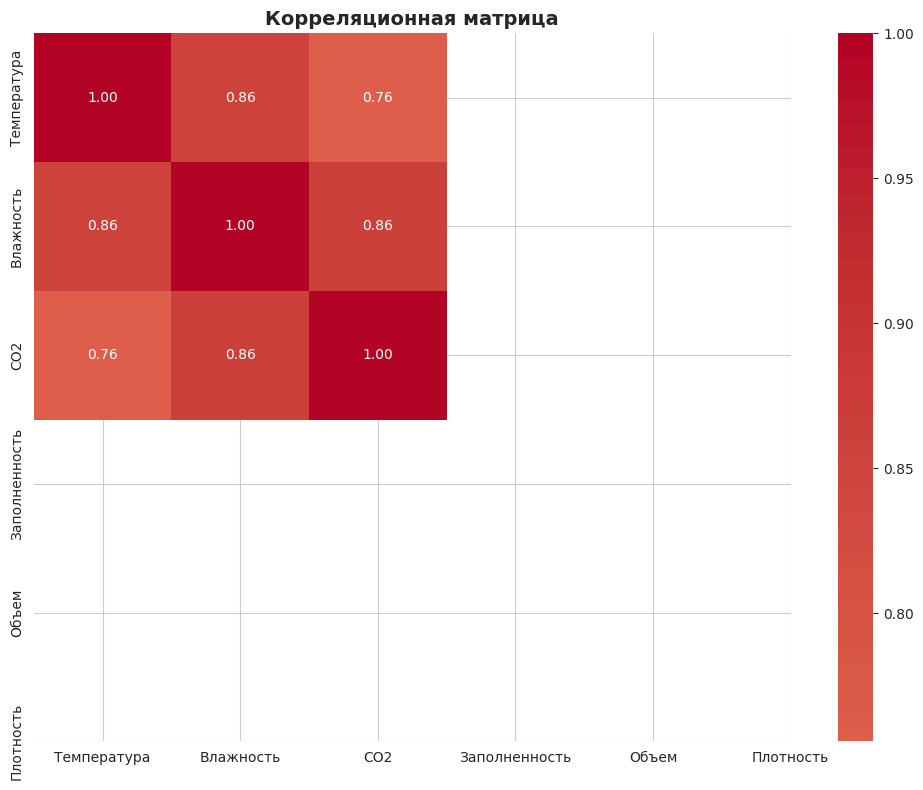

In [17]:
# Корреляция между параметрами
corr_cols = ['сглаженная_температура', 'сглаженная_влажность', 'сглаженный_co2',
             'Заполненность (чел)', 'Объем (куб)', 'Плотность (чел/м³)']
corr_matrix = df_labeled[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            xticklabels=['Температура', 'Влажность', 'CO2', 'Заполненность', 'Объем', 'Плотность'],
            yticklabels=['Температура', 'Влажность', 'CO2', 'Заполненность', 'Объем', 'Плотность'])
plt.title('Корреляционная матрица', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Экспорт данных

### 6.1. Подготовка финального датасета

In [ ]:
# Выбор колонок для экспорта
export_cols = [
    'datetime',
    'сглаженная_температура',
    'сглаженная_влажность',
    'сглаженный_co2',
    'Кабинет',
    'Примечание',
    'Объем (куб)',
    'Заполненность (чел)',
    'Плотность (чел/м³)',
    'CO2 на человека'
]

df_export = df_labeled[export_cols].copy()
df_export.columns = [
    'Время',
    'Температура (°C)',
    'Влажность (%)',
    'CO2 (ppm)',
    'Кабинет',
    'Примечание',
    'Объем (м³)',
    'Заполненность (чел)',
    'Плотность (чел/м³)',
    'CO2 на человека (ppm/чел)'
]

print(f"Подготовлено {len(df_export)} записей для экспорта")
df_export.head()

### 6.2. Экспорт в CSV

In [ ]:
csv_filename = 'co2_analysis_results.csv'
df_export.to_csv(csv_filename, index=False, encoding='utf-8-sig')
print(f"Данные экспортированы в {csv_filename}")

### 6.3. Экспорт в Excel

In [ ]:
excel_filename = 'co2_analysis_results.xlsx'

with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    df_export.to_excel(writer, sheet_name='Все данные', index=False)

    summary = df_labeled.groupby('Кабинет').agg({
        'сглаженная_температура': ['mean', 'min', 'max'],
        'сглаженная_влажность': ['mean', 'min', 'max'],
        'сглаженный_co2': ['mean', 'min', 'max'],
        'Примечание': 'first',
        'Объем (куб)': 'first',
        'Заполненность (чел)': 'first',
        'Плотность (чел/м³)': 'first'
    }).round(2)
    summary.to_excel(writer, sheet_name='Статистика')

    for cabinet in df_labeled['Кабинет'].unique():
        cabinet_data = df_export[df_export['Кабинет'] == cabinet]
        sheet_name = f'Кабинет {cabinet}'
        cabinet_data.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Данные экспортированы в {excel_filename}")
print(f"\nСоздано листов:")
print(f"  - Все данные: {len(df_export)} записей")
print(f"  - Статистика: сводка по {len(df_labeled['Кабинет'].unique())} кабинетам")
for cabinet in df_labeled['Кабинет'].unique():
    count = len(df_export[df_export['Кабинет'] == cabinet])
    print(f"  - Кабинет {cabinet}: {count} записей")

## Заключение

Анализ завершен. Результаты сохранены в файлы:
- `co2_analysis_results.csv` - все данные в формате CSV
- `co2_analysis_results.xlsx` - данные и статистика в формате Excel

Основные выводы можно сделать на основе визуализаций и статистики выше.